<a href="https://colab.research.google.com/github/CarolinaBRangel/Lista_Machine-Learning/blob/main/Carolina_Rangel_Lista_extra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
import io

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, LassoCV, ElasticNetCV, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Exercício 1

## Loading data

In [ ]:
uploaded = files.upload()
h = pd.read_csv(io.BytesIO(uploaded['house-prices.csv']))

## Arranging data

In [ ]:
features = ['OverallQual', 'GrLivArea', 'GarageCars']
features_y = ['OverallQual', 'GrLivArea', 'GarageCars', 'SalePrice']

df = h[features_y]

In [ ]:
df['SalePrice'] = pd.qcut(df['SalePrice'],q = 2, labels = ["-1", "1"])
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,OverallQual,GrLivArea,GarageCars,SalePrice
0,7,1710,2,1
1,6,1262,2,1
2,7,1786,2,1
3,7,1717,3,-1
4,8,2198,3,1


## Adaboost model

Let's begin by defining the functions to compute the error, calculate the performance, and update the weights after each interaction.

In [ ]:
def compute_error(y, y_pred, w_i):
    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

def compute_alpha(error):
    return np.log((1 - error) / error)

def update_weights(w_i, alpha, y, y_pred):
    return w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))

Now we need to define the Adaboost algorithm. To do so, I consulted the following source: https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50

In [ ]:
class AdaBoost:
    
    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y, M):
        '''
        Fit model. Arguments:
        X: independent variables - array-like matrix
        y: target variable - array-like vector
        M: number of boosting rounds. Default is 100 - integer
        '''
        
        # Clear before calling
        self.alphas = [] 
        self.training_errors = []
        self.M = M

        # Iterate over M weak classifiers
        for m in range(0, M):
            
            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_i
                w_i = update_weights(w_i, alpha_m, y, y_pred)
            
            # (a) Fit weak classifier and predict labels
            G_m = DecisionTreeClassifier(max_depth = 1)     # Stump: Two terminal-node classification tree
            G_m.fit(X, y, sample_weight = w_i)
            y_pred = G_m.predict(X)
            
            self.G_M.append(G_m) # Save to list of weak classifiers

            # (b) Compute error
            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.G_M) == len(self.alphas)

    def predict(self, X):

        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 

        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m

        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred 

## Split

In [ ]:
train, test = train_test_split(df, test_size=0.3, random_state=2)

X_train = train.drop('SalePrice', 1)
X_test = test.drop('SalePrice', 1)
y_train = train['SalePrice'].astype(int)
y_test = test[ 'SalePrice'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


## Model

In [ ]:
def mape(Y_actual, Y_Predicted):
    mape = np.mean(np.abs( Y_actual - Y_Predicted)/Y_actual)*100
    return mape

In [ ]:
ab = AdaBoost()
ab.fit(X_train, y_train, 50)
y_pred = ab.predict(X_test)

In [ ]:
mape(y_test, y_pred)

0.0

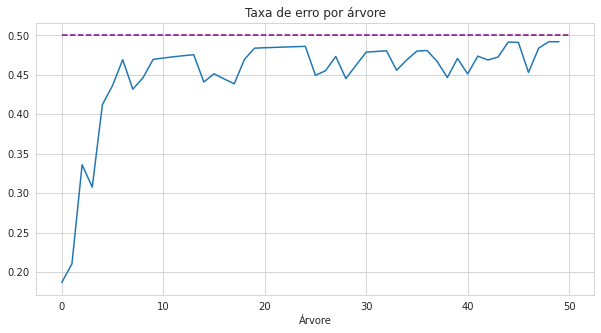

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(ab.training_errors)
plt.hlines(0.5, 0, 50, colors = 'purple', linestyles='dashed')
plt.title('Taxa de erro por árvore')
plt.xlabel('Árvore')
plt.show()

## Adaboost Model 2

In [ ]:
class AdaBoost:
    
    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.D = None
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y, M, D):
        '''
        Fit model. Arguments:
        X: independent variables - array-like matrix
        y: target variable - array-like vector
        M: number of boosting rounds. Default is 100 - integer
        '''
        
        # Clear before calling
        self.alphas = [] 
        self.training_errors = []
        self.M = M
        self.D = D

        # Iterate over M weak classifiers
        for m in range(0, M):
            
            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_i
                w_i = update_weights(w_i, alpha_m, y, y_pred)
            
            # (a) Fit weak classifier and predict labels
            G_m = DecisionTreeClassifier(max_depth = D)     # Stump: Two terminal-node classification tree
            G_m.fit(X, y, sample_weight = w_i)
            y_pred = G_m.predict(X)
            
            self.G_M.append(G_m) # Save to list of weak classifiers

            # (b) Compute error
            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.G_M) == len(self.alphas)

    def predict(self, X):

        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 

        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X).astype(int) * self.alphas[m].astype(int)
            weak_preds.iloc[:,m] = y_pred_m

        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred 

In [ ]:
ab = AdaBoost()
ab.fit(X_train, y_train, M = 50, D = 5)
y_pred = ab.predict(X_test)

In [ ]:
mape(y_test, y_pred)

1.5873015873015872

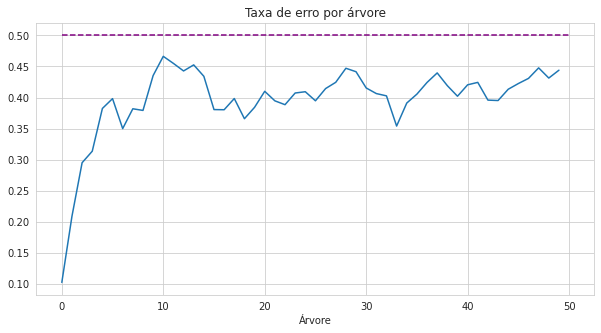

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(ab.training_errors)
plt.hlines(0.5, 0, 50, colors = 'purple', linestyles='dashed')
plt.title('Taxa de erro por árvore')
plt.xlabel('Árvore')
plt.show()

## Adaboost Model 3

In [ ]:
df_3 = h[features_y]

In [ ]:
df_3['SalePrice'] = pd.qcut(df_3['SalePrice'],q = 3, labels = [0, 1, 2])
df_3.head()

In [ ]:
class AdaBoost:
    
    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.D = None
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y, M, D):
        '''
        Fit model. Arguments:
        X: independent variables - array-like matrix
        y: target variable - array-like vector
        M: number of boosting rounds. Default is 100 - integer
        '''
        
        # Clear before calling
        self.alphas = [] 
        self.training_errors = []
        self.M = M
        self.D = D

        # Iterate over M weak classifiers
        for m in range(0, M):
            
            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_i
                w_i = update_weights(w_i, alpha_m, y, y_pred)
            
            # (a) Fit weak classifier and predict labels
            G_m = DecisionTreeClassifier(max_depth = D)     # Stump: Two terminal-node classification tree
            G_m.fit(X, y, sample_weight = w_i)
            y_pred = G_m.predict(X)
            
            self.G_M.append(G_m) # Save to list of weak classifiers

            # (b) Compute error
            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.G_M) == len(self.alphas)

    def predict(self, X):

        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 

        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X).astype(int) * self.alphas[m].astype(int)
            weak_preds.iloc[:,m] = y_pred_m

        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred 

In [ ]:
train, test = train_test_split(df_3, test_size=0.3, random_state=1)

X_train = train.drop('SalePrice', 1)
X_test = test.drop('SalePrice', 1)
y_train = train['SalePrice'].astype(int)
y_test = test[ 'SalePrice'].astype(int)

In [ ]:
ab = AdaBoost()
ab.fit(X_train, y_train, M = 400, D = 5)
y_pred = ab.predict(X_test)

In [ ]:
mape(y_test, y_pred)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(ab.training_errors)
plt.hlines(0.5, 0, 400, colors = 'purple', linestyles='dashed')
plt.title('Taxa de erro por árvore')
plt.xlabel('Árvore')
plt.show()

Another attempt, with code from here: https://github.com/jinxin0924/multi-adaboost/blob/master/multi_AdaBoost.py

In [ ]:
from numpy.core.umath_tests import inner1d
from copy import deepcopy


class AdaBoostClassifier(object):
    '''
    Parameters
    -----------
    base_estimator: object
        The base model from which the boosted ensemble is built.
    n_estimators: integer, optional(default=50)
        The maximum number of estimators
    learning_rate: float, optional(default=1)
    algorithm: {'SAMME','SAMME.R'}, optional(default='SAMME.R')
        SAMME.R uses predicted probabilities to update wights, while SAMME uses class error rate
    random_state: int or None, optional(default=None)
    Attributes
    -------------
    estimators_: list of base estimators
    estimator_weights_: array of floats
        Weights for each base_estimator
    estimator_errors_: array of floats
        Classification error for each estimator in the boosted ensemble.
    Reference:
    1. [multi-adaboost](https://web.stanford.edu/~hastie/Papers/samme.pdf)
    2. [scikit-learn:weight_boosting](https://github.com/scikit-learn/
    scikit-learn/blob/51a765a/sklearn/ensemble/weight_boosting.py#L289)
    '''

    def __init__(self, *args, **kwargs):
        if kwargs and args:
            raise ValueError(
                '''AdaBoostClassifier can only be called with keyword
                   arguments for the following keywords: base_estimator ,n_estimators,
                    learning_rate,algorithm,random_state''')
        allowed_keys = ['base_estimator', 'n_estimators', 'learning_rate', 'algorithm', 'random_state']
        keywords_used = kwargs.keys()
        for keyword in keywords_used:
            if keyword not in allowed_keys:
                raise ValueError(keyword + ":  Wrong keyword used --- check spelling")

        n_estimators = 50
        learning_rate = 1
        algorithm = 'SAMME.R'
        random_state = None

        if kwargs and not args:
            if 'base_estimator' in kwargs:
                base_estimator = kwargs.pop('base_estimator')
            else:
                raise ValueError('''base_estimator can not be None''')
            if 'n_estimators' in kwargs: n_estimators = kwargs.pop('n_estimators')
            if 'learning_rate' in kwargs: learning_rate = kwargs.pop('learning_rate')
            if 'algorithm' in kwargs: algorithm = kwargs.pop('algorithm')
            if 'random_state' in kwargs: random_state = kwargs.pop('random_state')

        self.base_estimator_ = base_estimator
        self.n_estimators_ = n_estimators
        self.learning_rate_ = learning_rate
        self.algorithm_ = algorithm
        self.random_state_ = random_state
        self.estimators_ = list()
        self.estimator_weights_ = np.zeros(self.n_estimators_)
        self.estimator_errors_ = np.ones(self.n_estimators_)


    def _samme_proba(self, estimator, n_classes, X):
        """Calculate algorithm 4, step 2, equation c) of Zhu et al [1].
        References
        ----------
        .. [1] J. Zhu, H. Zou, S. Rosset, T. Hastie, "Multi-class AdaBoost", 2009.
        """
        proba = estimator.predict_proba(X)

        # Displace zero probabilities so the log is defined.
        # Also fix negative elements which may occur with
        # negative sample weights.
        proba[proba < np.finfo(proba.dtype).eps] = np.finfo(proba.dtype).eps
        log_proba = np.log(proba)

        return (n_classes - 1) * (log_proba - (1. / n_classes)
                                  * log_proba.sum(axis=1)[:, np.newaxis])


    def fit(self, X, y):
        self.n_samples = X.shape[0]
        # There is hidden trouble for classes, here the classes will be sorted.
        # So in boost we have to ensure that the predict results have the same classes sort
        self.classes_ = np.array(sorted(list(set(y))))
        self.n_classes_ = len(self.classes_)
        for iboost in range(self.n_estimators_):
            if iboost == 0:
                sample_weight = np.ones(self.n_samples) / self.n_samples

            sample_weight, estimator_weight, estimator_error = self.boost(X, y, sample_weight)

            # early stop
            if estimator_error == None:
                break

            # append error and weight
            self.estimator_errors_[iboost] = estimator_error
            self.estimator_weights_[iboost] = estimator_weight

            if estimator_error <= 0:
                break

        return self


    def boost(self, X, y, sample_weight):
        if self.algorithm_ == 'SAMME':
            return self.discrete_boost(X, y, sample_weight)
        elif self.algorithm_ == 'SAMME.R':
            return self.real_boost(X, y, sample_weight)

    def real_boost(self, X, y, sample_weight):
        estimator = deepcopy(self.base_estimator_)
        if self.random_state_:
            estimator.set_params(random_state=1)

        estimator.fit(X, y, sample_weight=sample_weight)

        y_pred = estimator.predict(X)
        incorrect = y_pred != y
        estimator_error = np.dot(incorrect, sample_weight) / np.sum(sample_weight, axis=0)

        # if worse than random guess, stop boosting
        if estimator_error >= 1.0 - 1 / self.n_classes_:
            return None, None, None

        y_predict_proba = estimator.predict_proba(X)
        # repalce zero
        y_predict_proba[y_predict_proba < np.finfo(y_predict_proba.dtype).eps] = np.finfo(y_predict_proba.dtype).eps

        y_codes = np.array([-1. / (self.n_classes_ - 1), 1.])
        y_coding = y_codes.take(self.classes_ == y[:, np.newaxis])

        # for sample weight update
        intermediate_variable = (-1. * self.learning_rate_ * (((self.n_classes_ - 1) / self.n_classes_) *
                                                              inner1d(y_coding, np.log(
                                                                  y_predict_proba))))  #dot iterate for each row

        # update sample weight
        sample_weight *= np.exp(intermediate_variable)

        sample_weight_sum = np.sum(sample_weight, axis=0)
        if sample_weight_sum <= 0:
            return None, None, None

        # normalize sample weight
        sample_weight /= sample_weight_sum

        # append the estimator
        self.estimators_.append(estimator)

        return sample_weight, 1, estimator_error


    def discrete_boost(self, X, y, sample_weight):
        estimator = deepcopy(self.base_estimator_)
        if self.random_state_:
            estimator.set_params(random_state=1)

        estimator.fit(X, y, sample_weight=sample_weight)

        y_pred = estimator.predict(X)
        incorrect = y_pred != y
        estimator_error = np.dot(incorrect, sample_weight) / np.sum(sample_weight, axis=0)

        # if worse than random guess, stop boosting
        if estimator_error >= 1 - 1 / self.n_classes_:
            return None, None, None

        # update estimator_weight
        estimator_weight = self.learning_rate_ * np.log((1 - estimator_error) / estimator_error) + np.log(
            self.n_classes_ - 1)

        if estimator_weight <= 0:
            return None, None, None

        # update sample weight
        sample_weight *= np.exp(estimator_weight * incorrect)

        sample_weight_sum = np.sum(sample_weight, axis=0)
        if sample_weight_sum <= 0:
            return None, None, None

        # normalize sample weight
        sample_weight /= sample_weight_sum

        # append the estimator
        self.estimators_.append(estimator)

        return sample_weight, estimator_weight, estimator_error

    def predict(self, X):
        n_classes = self.n_classes_
        classes = self.classes_[:, np.newaxis]
        pred = None

        if self.algorithm_ == 'SAMME.R':
            # The weights are all 1. for SAMME.R
            pred = sum(self._samme_proba(estimator, n_classes, X) for estimator in self.estimators_)
        else:  # self.algorithm == "SAMME"
            pred = sum((estimator.predict(X) == classes).T * w
                       for estimator, w in zip(self.estimators_,
                                               self.estimator_weights_))

        pred /= self.estimator_weights_.sum()
        if n_classes == 2:
            pred[:, 0] *= -1
            pred = pred.sum(axis=1)
            return self.classes_.take(pred > 0, axis=0)

        return self.classes_.take(np.argmax(pred, axis=1), axis=0)


    def predict_proba(self, X):
        if self.algorithm_ == 'SAMME.R':
            # The weights are all 1. for SAMME.R
            proba = sum(self._samme_proba(estimator, self.n_classes_, X)
                        for estimator in self.estimators_)
        else:  # self.algorithm == "SAMME"
            proba = sum(estimator.predict_proba(X) * w
                        for estimator, w in zip(self.estimators_,
                                                self.estimator_weights_))

        proba /= self.estimator_weights_.sum()
        proba = np.exp((1. / (n_classes - 1)) * proba)
        normalizer = proba.sum(axis=1)[:, np.newaxis]
        normalizer[normalizer == 0.0] = 1.0
        proba /= normalizer

        return proba



In [ ]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import accuracy_score


X, y = make_gaussian_quantiles(n_samples=13000, n_features=10,
                               n_classes=3, random_state=1)

n_split = 3000

X_train = df_1[:train.shape[0]]
X_test = df_1[train.shape[0]:]
y_train = train.SalePrice
y_test = test.SalePrice

bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1)


bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")


bdt_real.fit(X_train, y_train)
bdt_discrete.fit(X_train, y_train)



n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

from sklearn.ensemble import AdaBoostClassifier as Ada

bdt_real_test = Ada(
    base_estimator=DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1)
bdt_real_test.fit(X_train, y_train)

bdt_discrete_test = Ada(
    base_estimator=DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1,
    algorithm='SAMME')
bdt_discrete_test.fit(X_train, y_train)


discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
test_real_errors=bdt_real_test.estimator_errors_[:]
test_discrete_errors=bdt_discrete_test.estimator_errors_[:]

plt.figure(figsize=(15, 5))
plt.subplot(221)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_errors,
         "b", label='SAMME', alpha=.5)
plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.ylim((.2,
         max(real_estimator_errors.max(),
             discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(222)
plt.plot(range(1, n_trees_real + 1), real_estimator_errors,
         "r", label='SAMME.R', alpha=.5,color='r')
plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.ylim((.2,
         max(real_estimator_errors.max(),
             discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(224)
plt.plot(range(1, n_trees_real + 1), test_real_errors,
         "r", label='test_real', alpha=.5, color='b')

plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.ylim((.2,
         max(real_estimator_errors.max(),
             discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(223)
plt.plot(range(1, n_trees_real + 1), test_discrete_errors,
         "r", label='test_discrete', alpha=.5)

plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.ylim((.2,
         max(real_estimator_errors.max(),
             discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))


from sklearn.metrics import accuracy_score

print(accuracy_score(bdt_real.predict(X_test),y_test))
print(accuracy_score(bdt_real_test.predict(X_test),y_test))
print(accuracy_score(bdt_discrete.predict(X_test),y_test))
print(accuracy_score(bdt_discrete_test.predict(X_test),y_test))
        

## Adaboost model 4

In [ ]:
regs = h[features_y]
train, test = train_test_split(regs, test_size=0.3, random_state=1)
X_train = train.drop('SalePrice', 1)
X_test = test.drop('SalePrice', 1)
y_train = train['SalePrice'].astype(int)
y_test = test[ 'SalePrice'].astype(int)


NameError: ignored

In [ ]:
class AdaBoost:
    
    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.D = None
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y, M, D):
        '''
        Fit model. Arguments:
        X: independent variables - array-like matrix
        y: target variable - array-like vector
        M: number of boosting rounds. Default is 100 - integer
        '''
        
        # Clear before calling
        self.alphas = [] 
        self.training_errors = []
        self.M = M
        self.D = D

        # Iterate over M weak classifiers
        for m in range(0, M):
            
            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_i
                w_i = update_weights(w_i, alpha_m, y, y_pred)
            
            # (a) Fit weak classifier and predict labels
            G_m = DecisionTreeRegressor(max_depth = D)     # Stump: Two terminal-node classification tree
            G_m.fit(X, y, sample_weight = w_i)
            y_pred = G_m.predict(X)
            
            self.G_M.append(G_m) # Save to list of weak classifiers

            # (b) Compute error
            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.G_M) == len(self.alphas)

    def predict(self, X):

        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 

        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X).astype(int) * self.alphas[m].astype(int)
            weak_preds.iloc[:,m] = y_pred_m

        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred 

In [ ]:
ab = AdaBoost()
ab.fit(X_train, y_train, M = 400, D = 5)

y_pred = ab.predict(X_test)

In [ ]:
mape(y_test, y_pred)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(ab.training_errors)
plt.hlines(0.5, 0, 400, colors = 'purple', linestyles='dashed')
plt.title('Taxa de erro por árvore')
plt.xlabel('Árvore')
plt.show()

# Exercício 2

## Loading data

In [ ]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['sky.csv']))

Saving sky.csv to sky.csv


## Data exploration

In [ ]:
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


There is only one variable, that of class, which is an object and I will need to transform in a numeric one later. That is because ML models usually do not accept variables that are not numbers.

In [ ]:
df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,1.577039e+05,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


There are no missing values, meaning there will be no need to imput values.
Also, the min, max and mean within each column is not dramatically different, so I believe outliers will not be a huge issue here.

Now lets take a look at how the depened variable is classified here

In [ ]:
df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

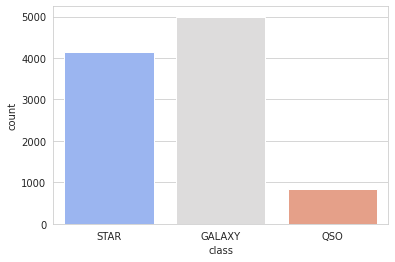

In [ ]:
sns.countplot(x='class',data=df, palette='coolwarm')

49.98% of the objects are galaxies, 41.52% are stars and 8.5% are quasar objects.

## Feature selection: Documentation



From the documentation, it is noticeable that the variables 'objective indetifier' (objid and specobjid) are just the identification of each objetc used to organize the original dataset, which has no effect in classification.

Also, there are four features that describe parts of the camera that was used when the object was registered. This also does not seem to matter when attempting to classify. 

Therefore, I will remove the abovementioned variables.

In [ ]:
df.drop(['objid', 'specobjid', 'run', 'rerun', 'camcol', 'field'], axis=1, inplace=True)

In [ ]:
df.head()

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,STAR,-0.000055,323,51615,541
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,GALAXY,0.123111,287,52023,513
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,STAR,-0.000111,3306,54922,510
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,STAR,0.000590,3306,54922,512


## Data Exploration

One variable, redshift, refers to light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum.

Reading about it online, it seems that it can be an estimate from how distant the objects in space are from earth. Thus, I will begin by looking for patterns in the redshift of each of the 3 possible classes.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


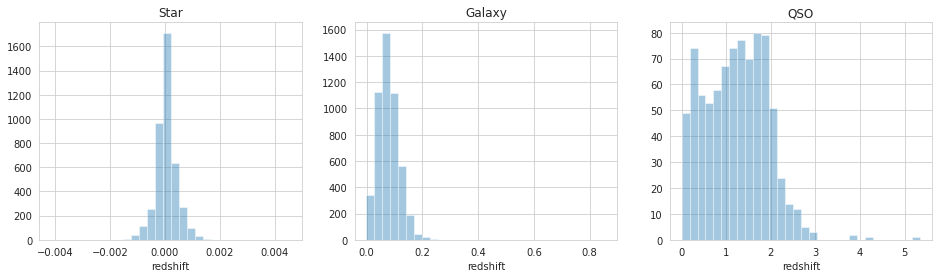

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(df[df['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(df[df['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(df[df['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

Indeed, the redshift is different for each of the three classes.

It seems stars are closer to earth, given they have the smallest redshifts. Also, their readshift seems to be the most concentrated, with values between -0.002 and 0.002.

Quasar objects are the the most far away, with values going from quite close (0) to very far (5). 

Galaxies are all at a higher than 0 redshift, but they remain between 0 and 0.2.

The importance here is that redshift will likely be a good predictor of the class.

Other variables in the dataset refer to the different wavelengths which are used to capture the observations - the 5 bands of the telescope. It is reasonable to believe that they may be correlated amongst themselves since different bands will have different 'distance' capacities.

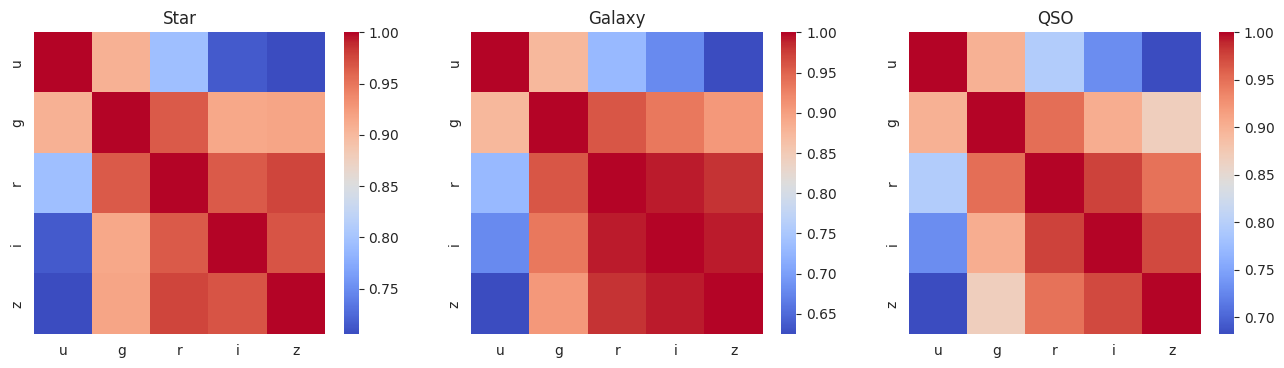

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.set_dpi(100)
ax = sns.heatmap(df[df['class']=='STAR'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[0], cmap='coolwarm')
ax.set_title('Star')
ax = sns.heatmap(df[df['class']=='GALAXY'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[1], cmap='coolwarm')
ax.set_title('Galaxy')
ax = sns.heatmap(df[df['class']=='QSO'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[2], cmap='coolwarm')
ax = ax.set_title('QSO')

The interesting thing is that u is less correlated with the other bands and, thus, it may be that the scope u cannot capture given the maximum distance it can reach.

Another two variables that seems to be interesting are ra and dec.

Right ascension (abbreviated RA) is the angular distance measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question. When paired with declination (abbreviated dec), these astronomical coordinates specify the direction of a point on the sky in the equatorial coordinate system.

Hence, my understaning is that they pin point where a celestial body is. Thus, they may indicate something about the classification of such bodies.

Text(0.5, 1.0, 'dec')

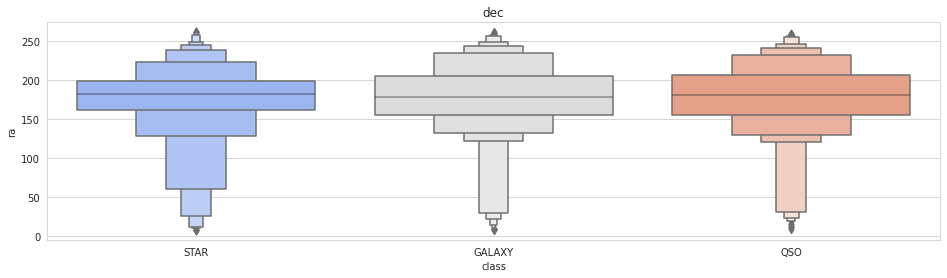

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 4))
ax = sns.boxenplot(x=df['class'], y=df['ra'], palette='coolwarm')
ax.set_title('dec')

# boxenplot is basically a boxplot with plots more quantiles and, thus, it is more accurate

The ra does not really tell much about each class, as the distribution is quite similar.

Text(0.5, 1.0, 'dec')

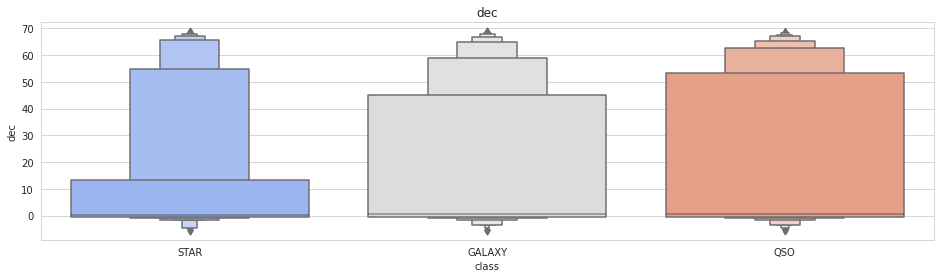

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 4))
ax = sns.boxenplot(x=df['class'], y=df['dec'], palette='coolwarm')
ax.set_title('dec')

The declination, however, is quite telling. 

For stares, the declination is mainly between 0 and 10, and another considerable part of the class is between 10 and 55.

Galaxys are mainly between 0 and 45, which a smaller amount between 45 and 60.

Quasar objects vary from 0 to a little over 50.

Thus, it seems the declination can also help differentiating mostly stars from galaxies and quasar objects.

But what happens when we look at them together?


/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Coordinates')

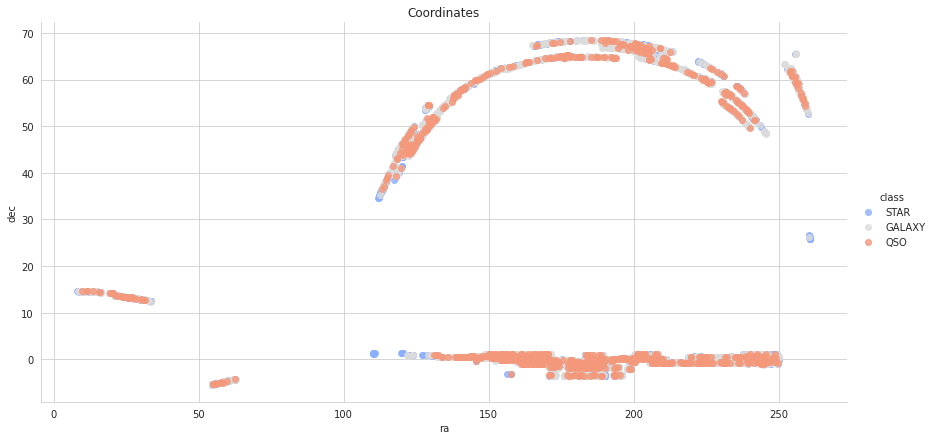

In [ ]:
sns.lmplot(x='ra', y='dec', data=df, hue='class', fit_reg=False, palette='coolwarm', size=6, aspect=2)
plt.title('Coordinates')

The full coordinates are very similar for the three classes. This goes against the assumption that the declination will help differentiating stars. 

Now let's take a look at the other variables

Plate represents the serial number of large, thin, circular metal plate that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


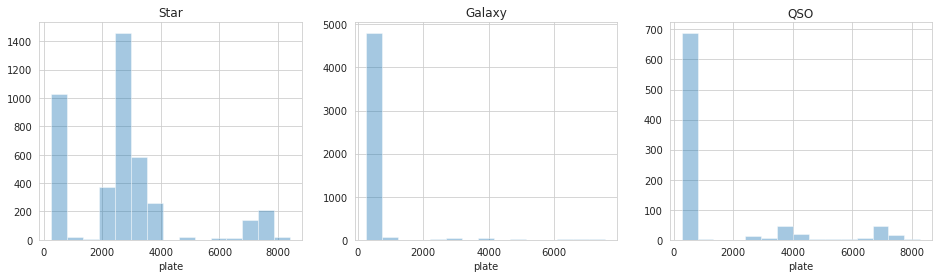

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(df[df['class']=='STAR'].plate, bins = 15, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(df[df['class']=='GALAXY'].plate, bins = 15, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(df[df['class']=='QSO'].plate, bins = 15, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

There may be an effect of the plate used given galaxies and quasar objects are 'found'mainly by plates closer to 0 whereas stars are more distributed between types of plates.

MJD indicates the date that a given piece of data (image or spectrum) was taken.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


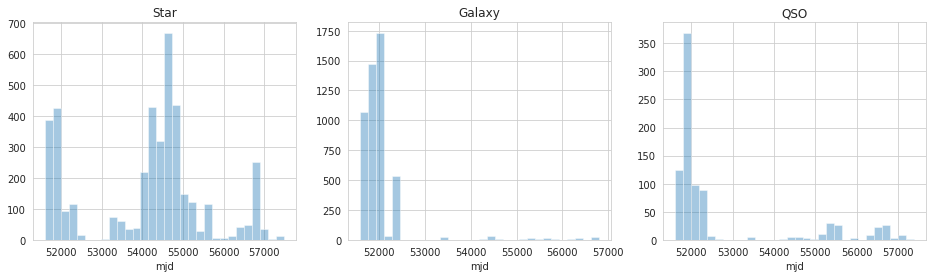

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(df[df['class']=='STAR'].mjd, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(df[df['class']=='GALAXY'].mjd, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(df[df['class']=='QSO'].mjd, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

Again, galaxies and quasar objects are more focues between 52000 and 53000 whereas star are all over the place.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


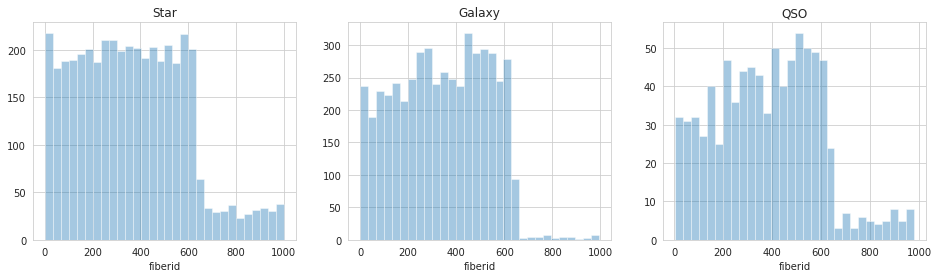

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(df[df['class']=='STAR'].fiberid, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(df[df['class']=='GALAXY'].fiberid, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(df[df['class']=='QSO'].fiberid, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

This last variable, fiberid, is simply the id of the optical fibers used to direct the light at the focal plane from individual objects to the slithead. 

It seems to be more equally distributed among the classes, but it is still worth to keep it, since the distance of celestial bodies mean differnt fiber optics are needed for certain distances.

## Feature selection: Exploratiom

We saw that the the 5 bands of the telescope are quite correlated to one another, even though u is a bit lower (under .80). Still, it like 'overkill' to keep the 5 variables in the dataset. 

Looking for ways to deal with this without having to simply choose one over another, I thought of Principal Component Analysis. (an example can be seen here https://www.kaggle.com/code/lucidlenn.)

In a nutsheel, n observations with p features can be interpreted as n points in a p-dimensional space. PCA aims to project this space into a q-dimensional subspace (with q<p).

It does so by finding the q directions in which the n points vary the most (--> the principal components). It then projects the original data points into the q-dimensional subspace. PCA returns a n x q dimensional matrix.

I will use this technique. 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
ugriz = pca.fit_transform(df[['u', 'g', 'r', 'i', 'z']])

df_p = pd.concat((df, pd.DataFrame(ugriz)), axis=1)
df_p.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
df_p.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
df_p.head()

,ra,dec,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,STAR,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598370,0.135285,STAR,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,GALAXY,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,STAR,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,STAR,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689


## Split

In [ ]:
df['class'] = df['class'].replace({'STAR': 1, 'GALAXY': 2, 'QSO': 3})
df_p['class'] = df_p['class'].replace({'STAR': 1, 'GALAXY': 2, 'QSO': 3})

In [ ]:
train, test = train_test_split(df, test_size = 0.3)
train_p, test_p = train_test_split(df_p, test_size = 0.3)

In [ ]:
x_train = train.drop('class', 1)
y_train = train['class']

x_test = test.drop('class', 1)
y_test = test['class']

x_train_p = train_p.drop('class', 1)
y_train_p = train_p['class']

x_test_p = test_p.drop('class', 1)
y_test_p = test_p['class']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


## Modelos 

Let's begin by running the models without focusing on hyperparemeters - just to see how they behave at first.

Primeiro sem o PCA

In [ ]:
def mape(Y_actual, Y_Predicted):
    mape = np.mean(np.abs( Y_actual - Y_Predicted)/Y_actual)*100
    return mape

In [ ]:
DTR = DecisionTreeClassifier(max_depth=5)
RFR =RandomForestClassifier()
BAG = BaggingClassifier()
ADA = AdaBoostClassifier()
GBR = GradientBoostingClassifier()
XGB = XGBClassifier(n_estimators=100).fit(x_train, y_train)

model_names = list(['DTR', 'RFR','BAG', 'ADA', 'GBR', 'XGB'])
model_list = list([DTR, RFR, BAG,ADA, GBR, XGB])

In [ ]:
mape_list = []
in_sample_preds = []
out_sample_preds = []
for model in model_list:
    model.fit(x_train, y_train)   
    in_sample_preds.append(model.predict(x_train))
    out_sample_preds.append(model.predict(x_test))
    mape_list.append(round(mape( y_test , model.predict(x_test)), 4))
mape_results_0 = pd.DataFrame({
    'Model': model_names,
    'MAPE': mape_list}
)
mape_results_0

,Model,MAPE
0,DTR,0.5333
1,RFR,0.5556
2,BAG,0.5444
3,ADA,6.6833
4,GBR,0.5444
5,KNN,14.5611
6,XGB,0.4778


Agora com o PCA

In [ ]:
DTR = DecisionTreeClassifier(max_depth=5)
RFR =RandomForestClassifier()
BAG = BaggingClassifier()
ADA = AdaBoostClassifier()
GBR = GradientBoostingClassifier()
XGB = XGBClassifier(n_estimators=100).fit(x_train_p, y_train_p)

model_names = list(['DTR', 'RFR','BAG', 'ADA', 'GBR', 'XGB'])
model_list = list([DTR, RFR, BAG,ADA, GBR, XGB])

In [ ]:
mape_list = []
in_sample_preds = []
out_sample_preds = []
for model in model_list:
    model.fit(x_train_p, y_train_p)   
    in_sample_preds.append(model.predict(x_train_p))
    out_sample_preds.append(model.predict(x_test_p))
    mape_list.append(round(mape(y_test_p , model.predict(x_test_p)), 4))
mape_results_1 = pd.DataFrame({
    'Model': model_names,
    'MAPE': mape_list}
)
mape_results_1

,Model,MAPE
0,DTR,0.3889
1,RFR,0.2278
2,BAG,0.4222
3,ADA,10.9611
4,GBR,0.1944
5,KNN,14.9667
6,XGB,0.1444


Since the PCA inproved accuracy, I will use the dataset that contains it.

## Hyperparemeter

To identify hyperparemeters, I will devide the training set into train and validation. 

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_p, y_train_p, test_size=0.15, random_state=5)

### Decision tree hyperparemeters

Text(0.5, 1.0, 'Performance on Training set and Validation set')

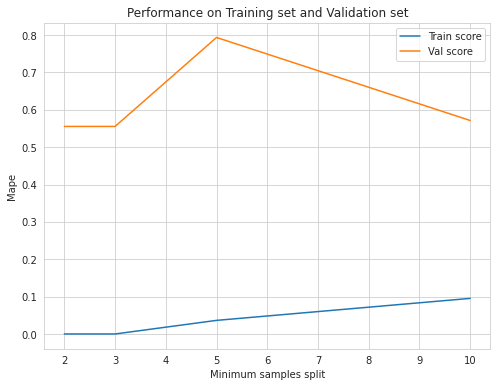

In [ ]:
min_samples_split = [2, 3, 5, 10]
accuracy_train = []
accuracy_val = []
for i in min_samples_split:
    clf = DecisionTreeClassifier(min_samples_split=i, random_state=1, min_samples_leaf=1)
    clf.fit(x_train, y_train)
    accr = mape(y_train, clf.predict(x_train))
    accuracy_train.append(accr)
    accr = mape(y_val, clf.predict(x_val))
    accuracy_val.append(accr)
f, ax = plt.subplots(1, figsize=(8,6))
plt.plot(min_samples_split, accuracy_train, label='Train score')
plt.plot(min_samples_split, accuracy_val, label='Val score')
plt.legend(loc='best')
plt.xlabel('Minimum samples split')
plt.ylabel('Mape')
plt.title('Performance on Training set and Validation set')

3 was chosen for the hyperparameter of min_samples_split as ir performed better on the val set.

Text(0.5, 1.0, 'Performance on Training set and Val set')

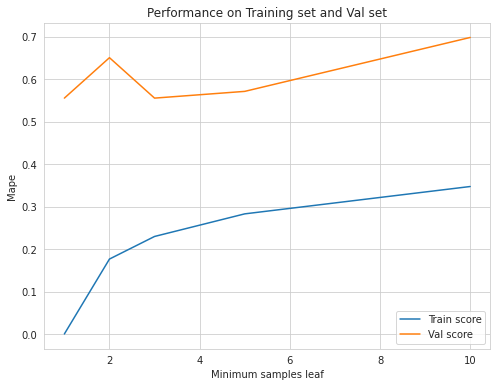

In [ ]:
min_samples_leaf = [1, 2, 3, 5, 10]
accuracy_train = []
accuracy_val = []
for i in min_samples_leaf:
    clf = DecisionTreeClassifier(min_samples_split=3, min_samples_leaf=i, random_state=1)
    clf.fit(x_train, y_train)
    accr = mape(y_train, clf.predict(x_train))
    accuracy_train.append(accr)
    accr = mape(y_val, clf.predict(x_val))
    accuracy_val.append(accr)
f, ax = plt.subplots(1, figsize=(8,6))
plt.plot(min_samples_leaf, accuracy_train, label='Train score')
plt.plot(min_samples_leaf, accuracy_val, label='Val score')
plt.legend(loc='best')
plt.xlabel('Minimum samples leaf')
plt.ylabel('Mape')
plt.title('Performance on Training set and Val set')

3 was chosen for min samples leaf as it performed better in the val

Text(0.5, 1.0, 'Performance on Training set and Val set')

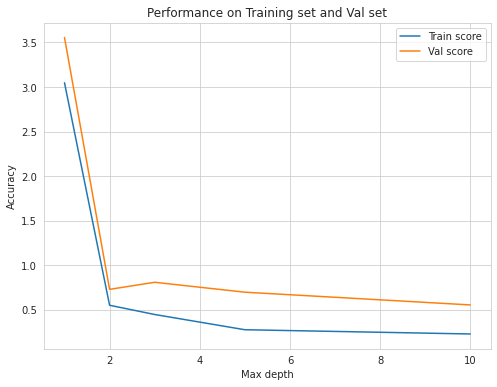

In [ ]:
max_depth = [1, 2, 3, 5, 10]
accuracy_train = []
accuracy_val = []
for i in max_depth:
    clf = DecisionTreeClassifier(min_samples_split=3, min_samples_leaf=3, max_depth = i, random_state=1)
    clf.fit(x_train, y_train)
    accr = mape(y_train, clf.predict(x_train))
    accuracy_train.append(accr)
    accr = mape(y_val, clf.predict(x_val))
    accuracy_val.append(accr)
f, ax = plt.subplots(1, figsize=(8,6))
plt.plot(max_depth, accuracy_train, label='Train score')
plt.plot(max_depth, accuracy_val, label='Val score')
plt.legend(loc='best')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Performance on Training set and Val set')

In [ ]:
DTR = DecisionTreeClassifier(min_samples_split=3, min_samples_leaf=2, max_depth = 10, random_state=1)
DTR.fit(x_train, y_train)
DTR_pred = DTR.predict(x_test_p)
print('Mape:', round(mape(y_test_p, DTR_pred), 2))

Mape: 0.4


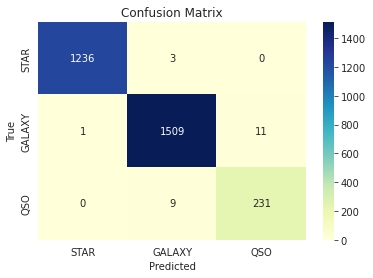

In [ ]:
from sklearn.metrics import confusion_matrix

cm_DTR = confusion_matrix(y_test_p, DTR_pred)

labels = ['STAR', 'GALAXY', 'QSO']

ax= plt.subplot()
sns.heatmap(cm_DTR, annot=True, fmt='g', ax=ax, cmap="YlGnBu"); 

ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

Text(0.5, 1.0, 'Feature Importance')

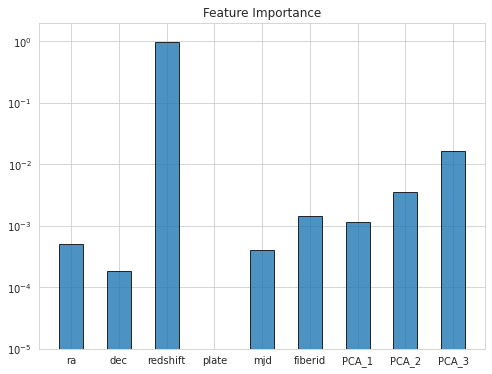

In [ ]:
feature_imp = pd.DataFrame({'Feature': x_train.columns,'Importance': clf.feature_importances_})
f = plt.subplots(1, figsize=(8,6))
plt.bar(feature_imp.Feature, feature_imp.Importance, log=True, alpha=0.8, width=0.5, edgecolor='k')
plt.ylim(1e-5, 2)
plt.title('Feature Importance')

### Random forest hyperparemeters

Text(0.5, 1.0, 'Performance on Training set and Val set')

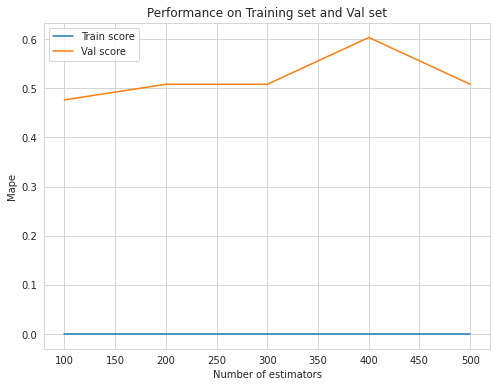

In [ ]:
n_estimators = [100, 200, 300, 400, 500]
accuracy_train = []
accuracy_val = []
for i in n_estimators:
    clf = RandomForestClassifier(n_estimators=i, random_state=1)
    clf.fit(x_train, y_train)
    accr = mape(y_train, clf.predict(x_train))
    accuracy_train.append(accr)
    accr = mape(y_val, clf.predict(x_val))
    accuracy_val.append(accr)
f, ax = plt.subplots(1, figsize=(8,6))
plt.plot(n_estimators, accuracy_train, label='Train score')
plt.plot(n_estimators, accuracy_val, label='Val score')
plt.legend(loc='best')
plt.xlabel('Number of estimators')
plt.ylabel('Mape')
plt.title('Performance on Training set and Val set')

100 was chosen as the pest parameter

Text(0.5, 1.0, 'Performance on Training set and Val set')

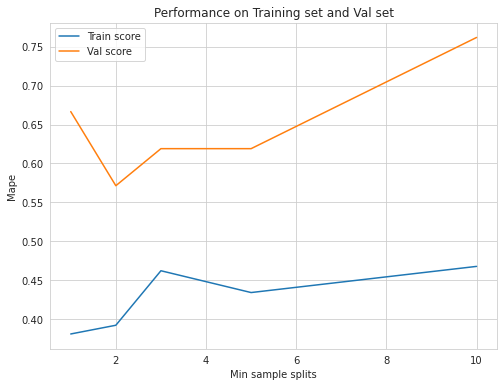

In [ ]:
min_samples_split = [1, 2, 3, 5, 10]
accuracy_train = []
accuracy_val = []
for i in n_estimators:
    clf = RandomForestClassifier(n_estimators=100, min_samples_split= i, random_state=1)
    clf.fit(x_train, y_train)
    accr = mape(y_train, clf.predict(x_train))
    accuracy_train.append(accr)
    accr = mape(y_val, clf.predict(x_val))
    accuracy_val.append(accr)
f, ax = plt.subplots(1, figsize=(8,6))
plt.plot(min_samples_split, accuracy_train, label='Train score')
plt.plot(min_samples_split, accuracy_val, label='Val score')
plt.legend(loc='best')
plt.xlabel('Min sample splits')
plt.ylabel('Mape')
plt.title('Performance on Training set and Val set')

2 was chosen

Text(0.5, 1.0, 'Performance on Training set and Val set')

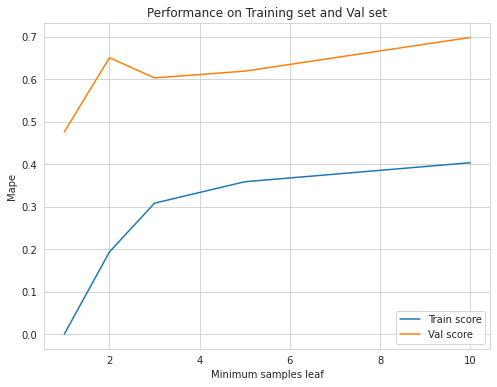

In [ ]:
min_samples_leaf = [1, 2, 3, 5, 10]
accuracy_train = []
accuracy_val = []
for i in min_samples_leaf:
    clf = RandomForestClassifier(n_estimators=100, min_samples_split= 2, min_samples_leaf=i, random_state=1)
    clf.fit(x_train, y_train)
    accr = mape(y_train, clf.predict(x_train))
    accuracy_train.append(accr)
    accr = mape(y_val, clf.predict(x_val))
    accuracy_val.append(accr)
f, ax = plt.subplots(1, figsize=(8,6))
plt.plot(min_samples_leaf, accuracy_train, label='Train score')
plt.plot(min_samples_leaf, accuracy_val, label='Val score')
plt.legend(loc='best')
plt.xlabel('Minimum samples leaf')
plt.ylabel('Mape')
plt.title('Performance on Training set and Val set')

1 was chosen

In [ ]:
RFR = RandomForestClassifier(n_estimators=100, min_samples_split= 2, min_samples_leaf=1, random_state=1)
RFR.fit(x_train, y_train)
RFR_pred = RFR.predict(x_test_p)
print('Mape:', round(mape(y_test_p, RFR_pred), 2))

Mape: 0.21


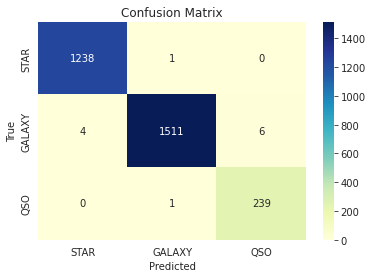

In [ ]:
cm_RFR = confusion_matrix(y_test_p, RFR_pred)

labels = ['STAR', 'GALAXY', 'QSO']

ax= plt.subplot()
sns.heatmap(cm_RFR, annot=True, fmt='g', ax=ax, cmap="YlGnBu"); 

ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

Text(0.5, 1.0, 'Feature Importance')

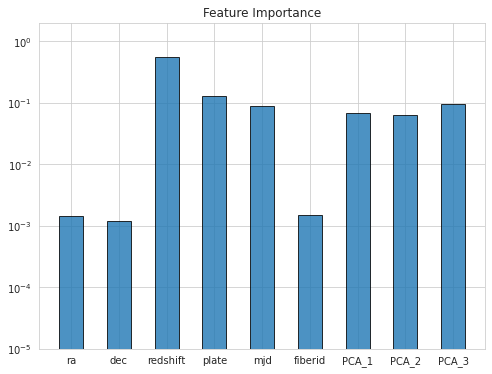

In [ ]:
feature_imp = pd.DataFrame({'Feature': x_train.columns,'Importance': clf.feature_importances_})
f = plt.subplots(1, figsize=(8,6))
plt.bar(feature_imp.Feature, feature_imp.Importance, log=True, alpha=0.8, width=0.5, edgecolor='k')
plt.ylim(1e-5, 2)
plt.title('Feature Importance')

### GradientBoosting

Text(0.5, 1.0, 'Performance on Training set and Validation set')

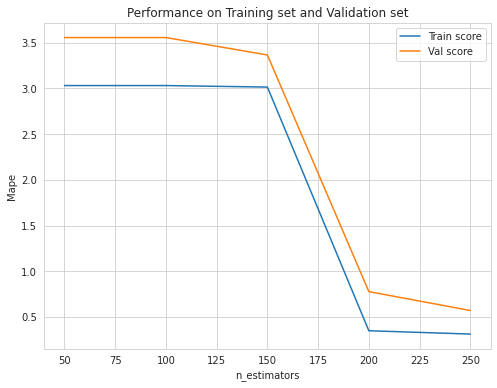

In [ ]:
n_estimators = [50, 100, 150, 200, 250]
accuracy_train = []
accuracy_val = []
for i in min_samples_split:
    clf = GradientBoostingClassifier(n_estimators = i, random_state=1)
    clf.fit(x_train, y_train)
    accr = mape(y_train, clf.predict(x_train))
    accuracy_train.append(accr)
    accr = mape(y_val, clf.predict(x_val))
    accuracy_val.append(accr)
f, ax = plt.subplots(1, figsize=(8,6))
plt.plot(n_estimators, accuracy_train, label='Train score')
plt.plot(n_estimators, accuracy_val, label='Val score')
plt.legend(loc='best')
plt.xlabel('n_estimators')
plt.ylabel('Mape')
plt.title('Performance on Training set and Validation set')

In [ ]:
GBR = GradientBoostingClassifier(n_estimators=250, random_state=1)
GBR.fit(x_train, y_train)
GBR_pred = GBR.predict(x_test_p)
print('Mape:', round(mape(y_test_p, GBR_pred), 2))

Mape: 0.17


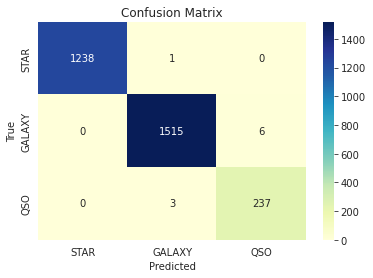

In [ ]:
cm_GBR = confusion_matrix(y_test_p, GBR_pred)

labels = ['STAR', 'GALAXY', 'QSO']

ax= plt.subplot()
sns.heatmap(cm_GBR, annot=True, fmt='g', ax=ax, cmap="YlGnBu"); 

ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

Text(0.5, 1.0, 'Feature Importance')

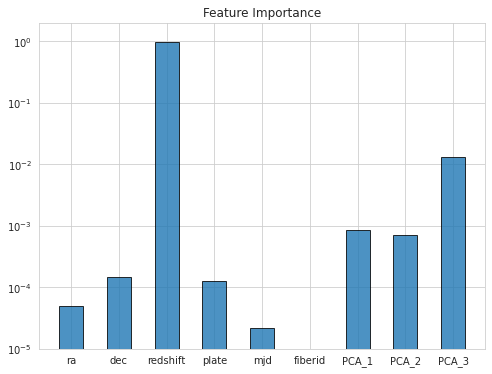

In [ ]:
feature_imp = pd.DataFrame({'Feature': x_train.columns,'Importance': clf.feature_importances_})
f = plt.subplots(1, figsize=(8,6))
plt.bar(feature_imp.Feature, feature_imp.Importance, log=True, alpha=0.8, width=0.5, edgecolor='k')
plt.ylim(1e-5, 2)
plt.title('Feature Importance')

### XGBoost

Text(0.5, 1.0, 'Performance on Training set and Validation set')

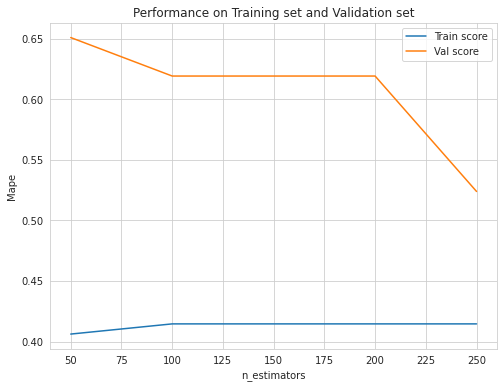

In [ ]:
n_estimators = [50, 100, 150, 200, 250]
accuracy_train = []
accuracy_val = []
for i in min_samples_split:
    clf = XGBClassifier(n_estimators = i, random_state=1)
    clf.fit(x_train, y_train)
    accr = mape(y_train, clf.predict(x_train))
    accuracy_train.append(accr)
    accr = mape(y_val, clf.predict(x_val))
    accuracy_val.append(accr)
f, ax = plt.subplots(1, figsize=(8,6))
plt.plot(n_estimators, accuracy_train, label='Train score')
plt.plot(n_estimators, accuracy_val, label='Val score')
plt.legend(loc='best')
plt.xlabel('n_estimators')
plt.ylabel('Mape')
plt.title('Performance on Training set and Validation set')

In [ ]:
XGB = XGBClassifier(n_estimators=250, random_state=1)
XGB.fit(x_train, y_train)
XGB_pred = XGB.predict(x_test_p)
print('Mape:', round(mape(y_test_p, XGB_pred), 2))

Mape: 0.13


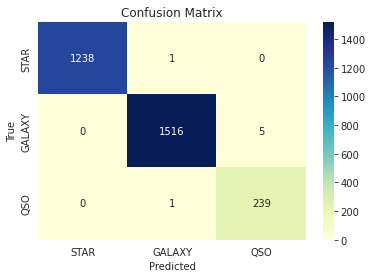

In [ ]:
cm_XGB = confusion_matrix(y_test_p, XGB_pred)

labels = ['STAR', 'GALAXY', 'QSO']

ax= plt.subplot()
sns.heatmap(cm_XGB, annot=True, fmt='g', ax=ax, cmap="YlGnBu"); 

ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

Text(0.5, 1.0, 'Feature Importance')

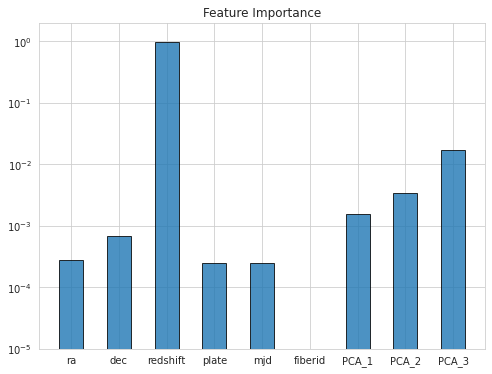

In [ ]:
feature_imp = pd.DataFrame({'Feature': x_train.columns,'Importance': clf.feature_importances_})
f = plt.subplots(1, figsize=(8,6))
plt.bar(feature_imp.Feature, feature_imp.Importance, log=True, alpha=0.8, width=0.5, edgecolor='k')
plt.ylim(1e-5, 2)
plt.title('Feature Importance')

### Permutation importance of the best models 

The best models were XGBoost and Gradient Boosting.

Permutation Importance judges the importance of a feature by how much it impacts model performance when it is removed.

I will use the sklearn and ELI5 library. 

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance

Gradient Boosting

In [ ]:
r = permutation_importance(GBR, x_test_p, y_test_p,
                           n_repeats=30,
                           random_state = 1)

gbr_importances = pd.Series(r.importances_mean, x_test_p.columns)

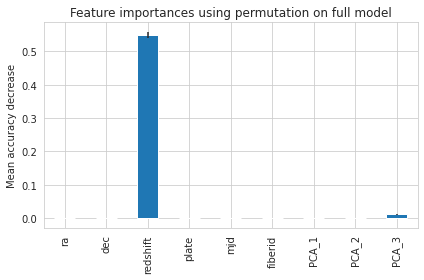

In [ ]:
fig, ax = plt.subplots()
gbr_importances.plot.bar(yerr=r.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
perm = PermutationImportance(GBR, random_state=1).fit(x_test_p, y_test_p)
eli5.show_weights(perm, 
                  feature_names = x_test_p.columns.tolist())

Weight,Feature
0.5509 ± 0.0135,redshift
0.0118 ± 0.0018,PCA_3
0.0016 ± 0.0009,PCA_2
0.0011 ± 0.0005,PCA_1
0.0007 ± 0.0004,plate
0.0007 ± 0.0006,ra
0.0005 ± 0.0007,dec
0.0002 ± 0.0003,mjd
0.0001 ± 0.0003,fiberid


XGBoost

In [ ]:
r = permutation_importance(XGB, x_test_p, y_test_p,
                           n_repeats=30,
                           random_state = 1)

xgb_importances = pd.Series(r.importances_mean, x_test_p.columns)

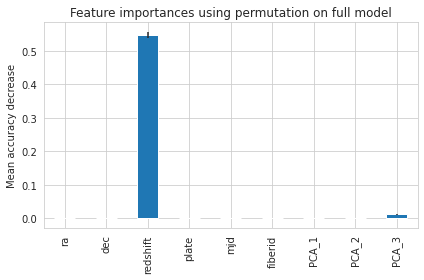

In [ ]:
fig, ax = plt.subplots()
xgb_importances.plot.bar(yerr=r.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
perm = PermutationImportance(XGB, random_state=1).fit(x_test_p, y_test_p)
eli5.show_weights(perm, 
                  feature_names = x_test_p.columns.tolist())

Weight,Feature
0.5483 ± 0.0138,redshift
0.0127 ± 0.0024,PCA_3
0.0010 ± 0.0004,PCA_1
0.0006 ± 0.0003,fiberid
0.0005 ± 0.0008,PCA_2
0.0004 ± 0.0003,plate
0.0003 ± 0.0005,dec
0.0002 ± 0.0003,mjd
0.0001 ± 0.0003,ra


# Exercício 3

## Loading Data

In [ ]:
#! pip install streamlit
import streamlit as st
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

2022-06-07 12:25:17.346 INFO    numexpr.utils: NumExpr defaulting to 2 threads.


In [ ]:
uploaded = files.upload()
eqp = pd.read_csv(io.BytesIO(uploaded['equip.csv']))
per = pd.read_csv(io.BytesIO(uploaded['perso.csv']))

Saving perso.csv to perso.csv
Saving equip.csv to equip.csv


In [ ]:
df = eqp.merge(per, on = ['date', 'day'], copy=False)

In [ ]:
df.head()

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,vehicles and fuel tanks,cruise missiles,personnel,personnel*,POW
0,2022-02-25,2,10,7,80,516,49,4,100.0,60.0,0,2,0,NaN,NaN,NaN,NaN,2800,about,0
1,2022-02-26,3,27,26,146,706,49,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,4300,about,0
2,2022-02-27,4,27,26,150,706,50,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,4500,about,0
3,2022-02-28,5,29,29,150,816,74,21,291.0,60.0,3,2,5,NaN,NaN,NaN,NaN,5300,about,0
4,2022-03-01,6,29,29,198,846,77,24,305.0,60.0,3,2,7,NaN,NaN,NaN,NaN,5710,about,200


In [ ]:
df = df.drop('personnel*', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
total = df.isnull().sum().sort_values(ascending=False)

percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat(
     [total, percent],
      axis=1,
      keys=['Total', 'Percent'])
      
missing_data.head(20)

,Total,Percent
cruise missiles,65,0.656566
vehicles and fuel tanks,65,0.656566
mobile SRBM system,63,0.636364
fuel tank,34,0.343434
military auto,34,0.343434
special equipment,19,0.191919
drone,0,0.000000
personnel,0,0.000000
anti-aircraft warfare,0,0.000000
naval ship,0,0.000000


In [ ]:
cols = ['cruise missiles', 'vehicles and fuel tanks', 'mobile SRBM system', 'military auto', 'fuel tank', 'special equipment']
df[cols] = df[cols].fillna(value = 0).astype(int)

## Plotly graphs

In [ ]:
# Create data
x, y = df['date'], df['personnel']

# Create plot
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=x, y=y,
                    mode='lines+markers',
                    name='lines+markers'))

fig.update_layout(legend_orientation="h",
                  legend=dict(x=0, y=1, traceorder="normal"),
                  title="Culmulative Human Losses",
                  xaxis_title="Date",
                  yaxis_title="Personnel ",
                  margin=dict(l=0, r=0, t=30, b=0))

fig.show()

In [ ]:
x = df['date']
y0 = df['aircraft']
y1 = df['helicopter']
y2 = df['anti-aircraft warfare']
y3 = df['drone']

# Create plot
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=x, y=y0,
                    mode='lines+markers',
                    name='Aircraft'))
fig.add_trace(go.Scatter(x=x, y=y1,
                    mode='lines+markers',
                    name='Helicopter'))
fig.add_trace(go.Scatter(x=x, y=y2,
                    mode='lines+markers',
                    name='Anti-aircraft warfare'))
fig.add_trace(go.Scatter(x=x, y=y3,
                    mode='lines+markers',
                    name='Drone'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=0, y=1, traceorder="normal"),
                  title="Weapons: Air",
                  xaxis_title="Date",
                  yaxis_title="Weapons ",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [ ]:
# Create data
x = df['date']
y0 = df['tank']
y1 = df['field artillery']
y2 = df['APC']
y3 = df['military auto']

# Create plot
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=x, y=y0,
                    mode='lines+markers',
                    name='Tank'))
fig.add_trace(go.Scatter(x=x, y=y1,
                    mode='lines+markers',
                    name='Field artillery'))
fig.add_trace(go.Scatter(x=x, y=y2,
                    mode='lines+markers',
                    name='APC'))
fig.add_trace(go.Scatter(x=x, y=y3,
                    mode='lines+markers',
                    name='Military auto'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=0, y=1, traceorder="normal"),
                  title="Weapons: Ground, Other",
                  xaxis_title="Date",
                  yaxis_title="Weapons ",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

## Dash

In [ ]:
!pip install pyngrok==4.1.1
from pyngrok import ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15983 sha256=6f6810c6151ed3d17ea96b9fd46983fa157c8b996e049ab6108a85317dd413ed
  Stored in directory: /root/.cache/pip/wheels/b1/d9/12/045a042fee3127dc40ba6f5df2798aa2df38c414bf533ca765
Successfully built pyngrok


In [ ]:
!streamlit run — server.port 8050 app.py &>/dev/null&

In [ ]:
!ngrok authtoken 2AFVbUPApkOWRQEokff0uZyBwL2_7RL8tUxG3mb2MEqhcEB9N

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
public_url = ngrok.connect('8050')

2022-06-07 12:38:00.808 INFO    pyngrok.process: ngrok process starting: 370
2022-06-07 12:38:00.826 INFO    pyngrok.process: t=2022-06-07T12:38:00+0000 lvl=info msg="no configuration paths supplied"

2022-06-07 12:38:00.830 INFO    pyngrok.process: t=2022-06-07T12:38:00+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml

2022-06-07 12:38:00.832 INFO    pyngrok.process: t=2022-06-07T12:38:00+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil

2022-06-07 12:38:00.841 INFO    pyngrok.process: t=2022-06-07T12:38:00+0000 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040

2022-06-07 12:38:01.042 INFO    pyngrok.process: t=2022-06-07T12:38:01+0000 lvl=info msg="tunnel session started" obj=tunnels.session

2022-06-07 12:38:01.045 INFO    pyngrok.process: t=2022-06-07T12:38:01+0000 lvl=info msg="client session established" obj=csess id=84078a83d197

2022-06-07 12:38:01.050 INFO    pyngrok.process: ngrok process has s

In [ ]:
public_url

'http://a11f-34-139-44-89.ngrok.io'

In [ ]:
st.title("**♟**Explore Personnel and Equipment Losses in the Russia-Ukraine War**♟**")
st.write("Here, you can see culmulative data regarding losses of personnel and military equipment since the beggining of the war.")

if st.checkbox('Show dataframe'):
   st.write(df)

# Create data
x, y = df['date'], df['personnel']

# Create plot
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=x, y=y,
                    mode='lines+markers',
                    name='lines+markers'))

fig.update_layout(legend_orientation="h",
                  legend=dict(x=0, y=1, traceorder="normal"),
                  title="Culmulative Human Losses",
                  xaxis_title="Date",
                  yaxis_title="Personnel ",
                  margin=dict(l=0, r=0, t=30, b=0))
st.plotly_chart(fig, use_container_width=True)

x = df['date']
y0 = df['aircraft']
y1 = df['helicopter']
y2 = df['anti-aircraft warfare']
y3 = df['drone']

# Create plot
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=x, y=y0,
                    mode='lines+markers',
                    name='Aircraft'))
fig.add_trace(go.Scatter(x=x, y=y1,
                    mode='lines+markers',
                    name='Helicopter'))
fig.add_trace(go.Scatter(x=x, y=y2,
                    mode='lines+markers',
                    name='Anti-aircraft warfare'))
fig.add_trace(go.Scatter(x=x, y=y3,
                    mode='lines+markers',
                    name='Drone'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=0, y=1, traceorder="normal"),
                  title="Weapons: Air",
                  xaxis_title="Date",
                  yaxis_title="Weapons ",
                  margin=dict(l=0, r=0, t=30, b=0))
st.plotly_chart(fig, use_container_width=True)

# Create data
x = df['date']
y0 = df['tank']
y1 = df['field artillery']
y2 = df['APC']
y3 = df['military auto']

# Create plot
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=x, y=y0,
                    mode='lines+markers',
                    name='Tank'))
fig.add_trace(go.Scatter(x=x, y=y1,
                    mode='lines+markers',
                    name='Field artillery'))
fig.add_trace(go.Scatter(x=x, y=y2,
                    mode='lines+markers',
                    name='APC'))
fig.add_trace(go.Scatter(x=x, y=y3,
                    mode='lines+markers',
                    name='Military auto'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=0, y=1, traceorder="normal"),
                  title="Weapons: Ground, Other",
                  xaxis_title="Date",
                  yaxis_title="Weapons ",
                  margin=dict(l=0, r=0, t=30, b=0))
st.plotly_chart(fig, use_container_width=True)



DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

The above code was not accepted in ngrock, so I got references here https://www.geeksforgeeks.org/create-interactive-dashboard-in-python-using-streamlit/ for the following code:

In [ ]:
st.title("**♟**Explore Personnel and Equipment Losses in the Russia-Ukraine War**♟**"))
st.markdown("Here, you can see culmulative data regarding losses of personnel and military equipment since the beggining of the war.")
st.sidebar.title("Selected the data you want")
st.sidebar.markdown("Select the graphs:")

data = df

chart_visual = st.sidebar.selectbox('Select the kind of graph', 
                                    ('Line Chart', 'Bar Chart', 'Bubble Chart'))
  
st.sidebar.checkbox("Show the data from the war", True, key = 1)
selected_status = st.sidebar.selectbox('Quantity over time',
                                       options = ['Tank', 
                                                  'Drone', 'Cruise Missiles', 
                                                  'Personnel', 'Field Artillery', 'Naval Ship',
                                                  'Aircrafts', 'Helicopters', 'POW', 'SRBM'])
  
fig = go.Figure()
  
if chart_visual == 'Line Chart':
  if selected_status == 'Tank':
    fig.add_trace(go.Scatter(x = df.day, y = df.tank,
                                 mode = 'lines',
                                 name = 'Tanks'))
  if selected_status == 'Drone':
        fig.add_trace(go.Scatter(x = df.day, y = df.drone,
                                 mode = 'lines', name = 'Drones'))
  if selected_status == 'Cruise Missiles':
        fig.add_trace(go.Scatter(x = df.day, y = df.cruisemissiles,
                                 mode = 'lines',
                                 name = 'Cruise Missiles'))
  if selected_status == 'Personnel': 
        fig.add_trace(go.Scatter(x=df.day, y=df.personnel,
                                 mode='lines',
                                 name="Personnel"))
  if selected_status == 'Field Artillery': 
        fig.add_trace(go.Scatter(x=df.day, y=df.fieldartillery,
                                 mode='lines',
                                 name="Artillery"))
  if selected_status == 'Naval Ship': 
        fig.add_trace(go.Scatter(x=df.day, y=df.navalship,
                                 mode='lines',
                                 name="Naval Ships"))
  if selected_status == 'Aircrafts': 
        fig.add_trace(go.Scatter(x=df.day, y=df.aircraft,
                                 mode='lines',
                                 name="Aircrafts")) 
  if selected_status == 'Helicopters': 
        fig.add_trace(go.Scatter(x=df.day, y=df.helicopter,
                                 mode='lines',
                                 name="Helicopters")) 
  if selected_status == 'POW': 
        fig.add_trace(go.Scatter(x=df.day, y=df.POW,
                                 mode='lines',
                                 name="POWs"))
  if selected_status == 'SRBM': 
        fig.add_trace(go.Scatter(x=df.day, y=df.mobileSRBMsystem,
                                 mode='lines',
                                 name="Mobile SRBM System"))         
         

elif chart_visual == 'Bar Chart':
  if selected_status == 'Tank':
        fig.add_trace(go.Bar(x = df.day, y = df.tank,
                                 mode = 'lines',
                                 name = 'Tanks'))
  if selected_status == 'Drone':
        fig.add_trace(go.Bar(x = df.day, y = df.drone,
                                 mode = 'lines', name = 'Drones'))
  if selected_status == 'Cruise Missiles':
        fig.add_trace(go.Bar(x = df.day, y = df.cruisemissiles,
                                 mode = 'lines',
                                 name = 'Cruise Missiles'))
  if selected_status == 'Personnel': 
        fig.add_trace(go.Bar(x=df.day, y=df.personnel,
                                 mode='lines',
                                 name="Personnel"))
  if selected_status == 'Field Artillery': 
        fig.add_trace(go.Bar(x=df.day, y=df.fieldartillery,
                                 mode='lines',
                                 name="Artillery"))
  if selected_status == 'Naval Ship': 
        fig.add_trace(go.Bar(x=df.day, y=df.navalship,
                                 mode='lines',
                                 name="Naval Ships"))
  if selected_status == 'Aircrafts': 
        fig.add_trace(go.Bar(x=df.day, y=df.aircraft,
                                 mode='lines',
                                 name="Aircrafts")) 
  if selected_status == 'Helicopters': 
        fig.add_trace(go.Bar(x=df.day, y=df.helicopter,
                                 mode='lines',
                                 name="Helicopters")) 
  if selected_status == 'POW': 
        fig.add_trace(go.Bar(x=df.day, y=df.POW,
                                 mode='lines',
                                 name="POWs")) 
  if selected_status == 'SRBM': 
        fig.add_trace(go.Bar(x=df.day, y=df.mobileSRBMsystem,
                                 mode='lines',
                                 name="Mobile SRBM System"))  
  
elif chart_visual == 'Bubble Chart':
  if selected_status == 'Tank':
        fig.add_trace(go.Scatter(x = df.day, y = df.tank,
                                 mode = 'lines',
                                 name = 'Tanks'))
  if selected_status == 'Drone':
        fig.add_trace(go.Scatter(x = df.day, y = df.drone,
                                 mode = 'lines', name = 'Drones'))
  if selected_status == 'Cruise Missiles':
        fig.add_trace(go.Scatter(x = df.day, y = df.cruisemissiles,
                                 mode = 'lines',
                                 name = 'Cruise Missiles'))
  if selected_status == 'Personnel': 
        fig.add_trace(go.Scatter(x=df.day, y=df.personnel,
                                 mode='lines',
                                 name="Personnel"))
  if selected_status == 'Field Artillery': 
        fig.add_trace(go.Scatter(x=df.day, y=df.fieldartillery,
                                 mode='lines',
                                 name="Artillery"))
  if selected_status == 'Naval Ship': 
        fig.add_trace(go.Scatter(x=df.day, y=df.navalship,
                                 mode='lines',
                                 name="Naval Ships"))
  if selected_status == 'Aircrafts': 
        fig.add_trace(go.Scatter(x=df.day, y=df.aircraft,
                                 mode='lines',
                                 name="Aircrafts")) 
  if selected_status == 'Helicopters': 
        fig.add_trace(go.Scatter(x=df.day, y=df.helicopter,
                                 mode='lines',
                                 name="Helicopters")) 
  if selected_status == 'POW': 
        fig.add_trace(go.Scatter(x=df.day, y=df.POW,
                                 mode='lines',
                                 name="POWs")) 
  if selected_status == 'SRBM': 
        fig.add_trace(go.Scatter(x=df.day, y=df.mobileSRBMsystem,
                                 mode='lines',
                                 name="Mobile SRBM System"))  

st.plotly_chart(fig, use_container_width=True)

In [ ]:
ngrok.kill()

2022-06-07 12:30:24.712 INFO    pyngrok.process: Killing ngrok process: 313


The tunnel that NGROCK shoudl ensemble so the dash can be visualized with the URL is quite unstable - it worked twice but then it did not load anymore. 